<a href="https://colab.research.google.com/github/Yuri-Nassar/mat_tree/blob/master/TCC_multiAspectClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm

## Bibliotecas

In [1]:
'''
  Requirements
'''
import os

import pandas as pd
import numpy as np
from collections import namedtuple, defaultdict
from graphviz import Digraph
# os.environ["PATH"] += os.pathsep + 'C:/Users/yuri.santos/Anaconda3/Library/bin/graphviz/'
import matplotlib.pyplot as plt
%matplotlib inline

import math
from copy import deepcopy
import plotly.graph_objects as go
import itertools
from IPython.display import display, display_html, HTML
import ipywidgets as widgets

# !pip install -U scikit-learn
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(10.7,7.27)})

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Yuri-Nassar/mat_tree/master/dataset/top_10/foursquare.csv")
df_muitas = pd.read_csv("https://raw.githubusercontent.com/Yuri-Nassar/mat_tree/master/dataset/top_10/muitas_top_10.csv")
df_msm = pd.read_csv("https://raw.githubusercontent.com/Yuri-Nassar/mat_tree/master/dataset/top_10/msm_top_10.csv")
df_edr = pd.read_csv("https://raw.githubusercontent.com/Yuri-Nassar/mat_tree/master/dataset/top_10/edr_top_10.csv")
df_lcss = pd.read_csv("https://raw.githubusercontent.com/Yuri-Nassar/mat_tree/master/dataset/top_10/lcss_top_10.csv")

In [ ]:
'''
  Load CSV files
    - df -> Foursquare csv file
    - df_muitas -> MUITAS matrix file
    - df_msm -> MSM matrix file
    - df_edr -> Edit distance for real dequence matrix file
    - df_lcss -> Longest common subsequence matrix file
'''

# path_file = "./dataset/top_10/" # local
dataset_setup = 'top_10'
dataset_setup = '193_usuarios'
path_file = "drive/MyDrive/Colab Notebooks/mat_tree/dataset/"+dataset_setup

if dataset_setup == 'top_10':
  df = pd.read_csv(path_file+"foursquare.csv")
  df_muitas = pd.read_csv(path_file+"muitas_top_10.csv")
  df_msm = pd.read_csv(path_file+"msm_top_10.csv")
  # df_edr = pd.read_csv("edr_top_10.csv")
  # df_lcss = pd.read_csv("lcss_top_10.csv")
elif dataset_setup == '193_usuarios':
  df = pd.read_csv("foursquare_3.csv")
  # df = pd.read_csv("Vania-Foursquare.csv")
  # df['price'] = df['price'].astype(str)
  # df['rating'] = df['rating'].astype(str)
  df_muitas = pd.read_csv("distancematrix_4s_muitas_193.csv")
  df_msm = pd.read_csv("distancematrix_4s_msm_193.csv")
  # df_edr = pd.read_csv("distancematrix_4s_edr_193.csv")
  # df_lcss = pd.read_csv("distancematrix_4s_lcss_193.csv")

# df = pd.read_csv("foursquare_50.csv")
# df_muitas = pd.read_csv('df_muitas_50.csv')
# df_msm = pd.read_csv('df_msm_50.csv')
# df_edr = pd.read_csv('df_edr_50.csv')
# df_lcss = pd.read_csv('df_lcss.csv')

In [3]:
df.head()

,tid,time,day,poi,type,root_type,rating,weather,label
0,5184,1056,Tuesday,my bed,Strip Club,Nightlife Spot,-1.0,Clear,185
1,5184,1099,Tuesday,nanas :),American Restaurant,Food,-1.0,Clear,185
2,5184,1191,Tuesday,The Bush Hot Tub :),Pool,Outdoors & Recreation,-1.0,Clear,185
3,5184,1261,Tuesday,The Hang Out,Other Nightlife,Nightlife Spot,-1.0,Clouds,185
4,5184,1320,Tuesday,The Bush Hideout,Speakeasy,Nightlife Spot,-1.0,Clouds,185


In [4]:
df.label.nunique()

10

## Algoritmo

### Sankey

In [7]:
def sankey(cls, label, value):
    """
      Creates a sankey diagram from class dataset. Sankey diagram is a type of
      flow diagram in which the width of the arrows is proportional to the
      flow rate.
    """

    label = list(itertools.chain.from_iterable(label.values()))
    value = list(itertools.chain.from_iterable(value.values()))
    source = [val for val in cls.source for _ in (0, 1)]
    target = [tar for tar in range(1, len(source) + 1)]

    link = dict(source=source, target=target, value=value)

    node = dict(label=label, pad=50, thickness=5)
    data = go.Sankey(link=link, node=node)
    fig = go.Figure(data)
    fig.show()

### EDA

In [11]:
def eda(cls, dataset, feature, usr):
      """
      Exploratory Data Analysis. It generates a plot bar of a given feature of 
      a given dataset and a given user. 

      Parameters
      ----------
      dataset : pandas.DataFrame
        Dataset of trajectories of a given cluster.
      feature : str
        Feature or Aspect intended for EDA.
      user : int
        User label in a given cluster.
      """
      idx = dataset.index
      
      df_total = df.copy()
      df1 = df[df.tid.isin(idx)]


      if usr is not None:
        df_total = df_total[df_total.label == usr]
        df1 = df1[df1.label == usr]

      
      df_total.reset_index(inplace=True)
      df1.reset_index(inplace=True)

      place_type_abs = df_total[feature]
      place_type = df1[feature]


      ''' Calculando a frequencia do cluster '''  
      values = np.sort(np.unique(place_type_abs))
      freq = np.zeros(len(values)) 
      ind = 0 
      for i in values:
          counter = 0
          for j in range(0,len(place_type)):
              if(place_type[j] == i):
                counter = counter + 1
          freq[ind] = counter
          ind = ind + 1

      ''' Calculando a frequencia absoluta '''
      values_abs = np.sort(np.unique(place_type_abs))
      freq_abs = np.zeros(len(values_abs)) 
      ind_abs = 0 
      for k in values_abs:
          counter = 0
          for l in range(0,len(place_type_abs)):
              if(place_type_abs[l] == k):
                counter = counter + 1
          freq_abs[ind_abs] = counter
          ind_abs = ind_abs + 1

      relative = []
      for i in range(len(freq)):
        relative.append(f'{(freq[i]/freq_abs[i])*100}')
      

      fig= plt.figure(figsize=(15,5))
      ax = plt.gca()
  

      y_pos = np.arange(len(values))
      plt.xticks(y_pos, values)
      plt.bar(y_pos, freq)
      plt.xticks(fontsize=10, rotation='vertical')
      plt.yticks(fontsize=10)
      plt.xlabel("Valores",fontsize = 15) 
      plt.ylabel("Frequência", fontsize = 15) 
      
      for i, p in enumerate(ax.patches):
          ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{int(p.get_height())} ({relative[i]:.4}%)',
                  fontsize=10, color='black', ha='center', va='bottom')

### EDA CORR

In [14]:
def eda_corr(cls, dataset, usr):
  """
  Exploratory Data Analysis. It generates a plot of correlation matrix of 
  all features of a given dataset and a given user. 

  Parameters
  ----------
  dataset : pandas.DataFrame
    Dataset of trajectories of a given cluster.
  user : int
    User label in a given cluster.
  """      
  idx = dataset.index
  ds = df[df.tid.isin(idx)]

  if usr is not None:
    ds = ds[ds.label == usr]

  columns = ['tid', 'time', 'poi', 'type', 'rating', 'label', 'weather']
  ds = ds.drop(columns=columns)
  corr = pd.get_dummies(ds)
  corr = corr.corr()

  plt.figure(figsize=(12, 7))
  plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
  plt.colorbar()
  plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
  plt.yticks(range(len(corr)), corr.columns);
  plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
  plt.grid(False)

### TreeNode

In [15]:
class TreeNode:

    """
      A class used to represent a node in a Tree.

      Attributes
      ----------
      TODO

      Methods
      -------
      set_level: Defines the cluster label.
      check_label: Method used to verify cluster aspect label in order to avoid 
                   duplicate names in Sankey Diagram.
      sankey: Creates a sankey diagram from class dataset. Sankey diagram is a 
              type of flow diagram in which the width of the arrows is 
              proportional to the flow rate.
      eda: Exploratory Data Analysis. It generates a plot bar of a given feature of 
            a given dataset and a given user. 
      eda_corr: Exploratory Data Analysis. It generates a plot of correlation 
                matrix of all features of a given dataset and a given user.
      get_similarity_matrix: Creates the distance matrix of the trajectories of 
                             a given cluster using the given similarity metric. 
      get_entropy: Calculates the entropy value of a given dataset. 
      dashboard: Displays the result dashboard.  
      show: Shows info about each cluster node.
      graphicTree: Shows info about each cluster node in the tree generated by Digraph 
                  plot.
      dashTree: Method that calculates the frequency matrix and the clusters 
                generated from the division of data based on a split criteria 
                defined in the Tree constructor. 

    """

    # Select option in dashboard
    SELECT = 'Select Node'  
    ALL = 'ALL'            
    HEATMAP = 'HEATMAP'

    # Sankey diagram params
    label = defaultdict(list)
    value = defaultdict(list)
    source = []
    
    id_dict = defaultdict(list)
    id_list = []

    # Params to label tree nodes
    nodeNum,targetNum = -1,-1 
    nodeLabel = defaultdict(list)

    # 1. Dictionary of all nodes dataframes
    # 2. Dictionary of all leaves nodes dataframes
    df_dict = {}
    df_leaves = {}

    ############################################################################
    # Frequency matrix for the initial dataset
    absolute_frequency_matrix = None
    relative = True

    ############################################################################
    temporario = 0
    clusters = 0
    dendrogram_dict = defaultdict(list)

    ############################################################################
    var_dict = {}
    id_iter = itertools.count()

    temp = {}
   
    def __init__(self, df, par=None):
      """DOC - __init__"""
    
      self.parent = par
      self.parentName = ''
      self.data = df
      self.left = None
      self.leftChildName = ''
      self.right = None
      self.rightChildName = ''
      self.done = 'No'
      self.freqMatrix = None
      self.variance = None
      self.threshold = None
      self.left_group = {}
      self.right_group = {}
      
      self.division = ''
      self.thresholdVal = None
      self.maxTrajPerGroup = 50
      self.maxDepth = 8
      # self.maxTrajPerGroup = 25
      # self.maxDepth = 10

      if par == None:
        # binary, minVariance, var_red, max_red
          self.split = 'max_red'
      else:
          self.split = par.split

      self.trajList = self.data.tid.unique() 
      self.useCol = ['day', 'weather', 'root_type'] 
      # self.useCol = ['price', 'rating', 'root_type'] 
 

      if self.parent is not None:
          self.skipVal = deepcopy(self.parent.skipVal)
      else:
          self.skipVal = []
      
      if self.parent == None:
          self.depth = 0
      else:
          self.depth = par.depth + 1

      if par==None:
        self.id = f'Lvl {self.depth}'
      else:
        self.id = self.set_level(self.depth)  

    def set_level(self, depth):
      """ 
      Defines the cluster label.

      Parameters
      ----------
      depth : int
        Tree depth level.
      """
      id = 0
      while True:
        if id not in self.id_dict[depth]:
           self.id_dict[depth].append(id)
           return f'Lvl {depth} - {id}'
        if id in self.id_dict[depth]:
          id += 1

    def check_label(self, label, depth):
      """
      Method used to verify cluster aspect label in order to avoid duplicate
      names in Sankey Diagram.

      Parameters
      ----------
      label : str
        Cluster aspect label.
      depth : int
        Cluster depth level.
      """

      items = list(itertools.chain.from_iterable(dict(TreeNode.label).values()))
        
      if label in items:
          if '#' in label:
              label, num = label.split('#')
              label += f'#{int(num)+1}'
          else:
              label += f'#1'
              self.check_label(label, depth)
      else:
          TreeNode.label[depth].append(label)
    
    
    # def showHeatmap(cls, node_id, annot=True):
    #     print(f'Número de Trajetórias: {cls.df_dict[node_id].shape[0]}')
    #     ax = sns.heatmap(cls.df_dict[node_id], annot=annot)  #cmap="YlGnBu"
        
    
    # def show_clustermap(cls, node_id):
    #     print(f'Número de Trajetórias: {cls.df_dict[node_id].shape[0]}')
    #     sns.clustermap(cls.df_dict[node_id])      
      
    @classmethod
    def get_entropy(cls, dataset):
      """
        Calculates the entropy value of a given dataset. 

        Parameters
        ----------
        dataset : pandas.DataFrame
          Dataset of trajectories of a given cluster

        Returns
        -------
        Float
          Entropy value of a given cluster.          
      """
      df1 = dataset.copy()
      entropy_dict = {}
      for e in df1.label.unique():
        num_traj = df1[df1.label == e].tid.unique()
        entropy_dict[e] = len(num_traj)
      total = sum(entropy_dict.values())

      entropy_value = 0
      for key, value in entropy_dict.items():
        p = value/total
        entropy_value += p * math.log2(p)

      try:
        max_entropy = math.log2(len(df1.label.unique()))
        return -entropy_value/max_entropy
      except:
        return -entropy_value
      # return -entropy_value/max_entropy

    
    def generate_freq_matrix(self):

        columns = self.data.drop(['time', 'poi', 'type', 'rating', 'label', 'weather'], axis=1)
        # columns = self.data.drop(['time', 'poi', 'type', 'rating', 'label'], axis=1)

        # Situação 1: check-in general category, price and rating level
        # columns = self.data.drop(['checkin_id', 'venue_id', 'lat_lon', 'date_time', 'time', 'day', 'poi', 'type', 'weather', 'label'], axis=1)
        # Situação 2: weather, day of the week and check-in general category
        # columns = self.data.drop(['checkin_id', 'venue_id', 'lat_lon', 'date_time', 'time', 'poi', 'type', 'price', 'rating', 'label'], axis=1)
        dummies = pd.get_dummies(columns, prefix_sep='~')
        vals = dummies.drop(['tid'], axis=1)
        self.freqMatrix = pd.pivot_table(dummies, index=['tid'], values=vals.columns, aggfunc=np.sum)
        

    @classmethod
    def dashboard(cls, array):
        """
          Displays the result dashboard.  

          output: displays the frequency matrix of a given cluster
          output_3: displays the graphic tree 
          output_4: displays the Sankey Diagram
          output_5: displays the cluster pandas.Dataset and info about the cluster
          output_6: displays EDA plots of a given cluster
          output_8: displays the similarity matrix of a given cluster
          plot_output: displays the heat map plots of a given cluster

          Parameters
          ----------
          array : dict
            Dictionary of resulting nodes. 
        
        """

        root = cls(df)
        # TreeNode.generate_freq_matrix()
        # TreeNode.absolute_frequency_matrix = self.freqMatrix.copy()
        root.dashTree()

        def getDictKeys(array):
            keys = list(array.keys())
            keys.sort()
            keys.insert(0, cls.SELECT)
            keys.insert(1, cls.ALL)
            return keys

        def getUsers(df):
            user = df.label.unique().tolist()
            user.insert(0, cls.ALL)
            return user

        dropdown_df = widgets.Dropdown(options = getDictKeys(TreeNode.df_dict), description='Tree Node')
        row_num = widgets.IntText(value=5, step=1, description='# rows')
        dropdown_label = widgets.Dropdown(options = getUsers(df), description='Select User')
        item_layout = widgets.Layout(margin='0 0 50px 0')
        
        input_widgets = widgets.HBox([dropdown_df, row_num, dropdown_label],layout=item_layout)
        
        
        output = widgets.Output()
        output_2 = widgets.Output()
        output_3 = widgets.Output()
        output_4 = widgets.Output()
        output_5 = widgets.Output()
        output_6 = widgets.Output()
        output_7 = widgets.Output()
        output_8 = widgets.Output()
        plot_output = widgets.Output()
        
        tab = widgets.Tab([output_3, output_5, output_8, output_6, output, output_4, plot_output],layout=item_layout)

        
        def update_dashboard(dataset, num, user):

            output.clear_output()
            output_2.clear_output()
            output_3.clear_output()
            output_4.clear_output()
            output_5.clear_output()
            output_6.clear_output()
            output_7.clear_output()
            output_8.clear_output()
            plot_output.clear_output()
            
            
            with output:
                if (dataset == cls.ALL) or (dataset == cls.SELECT):
                    display(df.head(num))
                else:
                    display(TreeNode.df_dict[dataset].head(num))
                    
            # with output_2:
            #     if (dataset == cls.ALL) or (dataset == cls.SELECT):
            #         print(f'The original dataset has {len(df.tid.unique())} trajectories.')
            #         display(df.describe())
            #     else:
            #         print(f'The node {dataset} has {TreeNode.df_dict[dataset].shape[0]} trajectories.')
            #         display(TreeNode.df_dict[dataset].describe())

            with output_3:
                graph = Digraph()
                # graph.attr(size="12")
                # graph.attr(size="18")
                graph.attr(size="22")
                graph.attr()
                root.graphicTree(graph)
                


                display(graph)

            with output_4:
                sankey(cls, TreeNode.label, TreeNode.value)
                            
            with output_5:
               if (dataset == cls.ALL) or (dataset == cls.SELECT):
                    display(df.head(num))
               else:
                    idx = TreeNode.df_dict[dataset].index
                    df_filter = df[df.tid.isin(idx)]
                    # users = df_filter.label.unique().tolist()
                    # print(df_filter.label)
                    print(f'The users in this node are: {df_filter.label.unique()}')
                    print(f'# users: {len(df_filter.label.unique())}')
                    print(f'There are {len(df_filter.tid.unique())} trajectories in this node.\n')

                    #print(f'Tras/Users {len(df_filter.tid.unique())/len(df_filter.label.unique())} trajectories in this node.\n')
                    print(f'Entropy (Trajectories/User): {TreeNode.get_entropy(df_filter)}\n')

                    if user == 'ALL':
                      display(df_filter)

                    if user in df_filter.label.unique():
                      dt = df_filter[df_filter.label == user]
                      print(f'Showing results for user {user}. User {user} has {len(dt.tid.unique())} different trajectories.')
                      print(f'Trajectory(ies) are: {[x for x in dt.tid.unique()]}')
                      display(dt)
                    else:
                      if user != 'ALL':
                        print('This user is not present in this node.')

            with output_6:
                
                if user == 'ALL':
                  eda(cls, TreeNode.df_dict[dataset], 'root_type', usr=None)
                else:
                  eda(cls, TreeNode.df_dict[dataset], 'root_type', usr=user)
                
                if user == 'ALL':
                  eda(cls, TreeNode.df_dict[dataset], 'day', usr=None)
                else:
                  eda(cls, TreeNode.df_dict[dataset], 'day', usr=user)
                if user == 'ALL':
                  eda_corr(cls, TreeNode.df_dict[dataset], usr=None)
                else:
                  eda_corr(cls, TreeNode.df_dict[dataset], usr=user)
                plt.show()

            with output_7:
              display(TreeNode.var_dict[dataset])

            with output_8:
              if (dataset == cls.ALL) or (dataset == cls.SELECT):
                    print("Select node.")
              else:
                    idx = TreeNode.df_dict[dataset].index
                    df_filter = df[df.tid.isin(idx)]

                    similarity_mean_node_muitas = cls.get_similarity_matrix(df_filter, 'MUITAS')
                    similarity_mean_node_muitas = sum(similarity_mean_node_muitas.mean())/len(similarity_mean_node_muitas)

                    similarity_mean_node_msm = cls.get_similarity_matrix(df_filter, 'MSM')
                    similarity_mean_node_msm = sum(similarity_mean_node_msm.mean())/len(similarity_mean_node_msm)
                    print(f'MUITAS')
                    print(f'The average of similarity between the trajectories of this cluster is: {similarity_mean_node_muitas}')
                    print(f'MSM')
                    print(f'The average of similarity between the trajectories of this cluster is: {similarity_mean_node_msm}')

                    print('\nSimilarity Matrix:')

                    display(TreeNode.get_similarity_matrix(df_filter, 'MUITAS'))                    

            with plot_output:
                if (dataset == cls.ALL):
                    sns.heatmap(df)
                else:
                    sns.heatmap(TreeNode.df_dict[dataset])
                plt.show()
            
        def dropdown_eventhandler(change):
            update_dashboard(change.new, row_num.value, dropdown_label.value)
                    
        def row_num_eventhandler(change):
            update_dashboard(dropdown_df.value, change.new, dropdown_label.value)
        
        def dropdown_label_eventhandler(change):
            update_dashboard(dropdown_df.value, row_num.value, change.new)


        dropdown_df.observe(dropdown_eventhandler, names='value')
        row_num.observe(row_num_eventhandler, names='value')
        dropdown_label.observe(dropdown_label_eventhandler, names='value')


        tab.set_title(0, 'Tree View')
        tab.set_title(1, 'Trajectory View')
        tab.set_title(2, 'Trajectory Similarity')
        tab.set_title(3, 'EDA')
        tab.set_title(4, 'Dataset Exploration')
        tab.set_title(5, 'Sankey View')
        tab.set_title(6, 'Heatmap Plot')
        # tab.titles = ['Tree View','Trajectory View','Trajectory Similarity','EDA','Dataset Exploration','Sankey View',
        #               'Heatmap Plot']
       

        display_dashboard = widgets.VBox([input_widgets, tab])
        display(display_dashboard)

    def show(self, onlyLeaf=False):
        """
          Shows info about each cluster node.

          Parameters
          ----------
          onlyLeaf : bool
            A boolean attribute to determine if all nodes should be displayed
            or only leaf nodes.       
        """

        if not onlyLeaf or len(self.division) <= 0:
            print('==' * self.depth, 'Node id: ', self.id)
            if self.parent == None:
                print('==' * self.depth, 'Parent id: None')
            else:
                print('==' * self.depth, 'Parent id: ', self.parent.id)
                print('==' * self.depth, 'Node depth: ', self.depth)
                print('==' * self.depth, 'Dataset shape (points x aspects): ', self.data.shape)
                print('==' * self.depth, 'Number of trajectories: ', self.trajList.size)
                print('==' * self.depth, '# of Users on this node =', self.data.label.unique().size)
                print('==' * self.depth, 'Users on this node =', self.data.label.unique())
            if len(self.division) > 0:
                print('==' * self.depth, 'Division done using the aspect', self.division['aspect'], ' with the value ',
                      self.division['value'], '; Frequency threshold = ', self.threshold)
                print('==' * self.depth, 'Trajectories on the left node = ', self.left.trajList.size)
                print('==' * self.depth, 'Trajectories on the right node = ', self.right.trajList.size)
            else:
                print('==' * self.depth, 'Leaf node')
            print(' ')

        if (self.left != None):
            self.left.show(onlyLeaf)
        if (self.right != None):
            self.right.show(onlyLeaf)

    def graphicTree(self, graphTree):
        """
          Shows info about each cluster node in the tree generated by Digraph 
          plot.

          Parameters
          ----------
          graphTree : Digraph
            A base class for directed graphs.       
        """     

        threshold = '{:.4f}'.format(self.thresholdVal)
        if self.left.thresholdVal != None and self.right.thresholdVal != None:
            thresholdLeft = '{:.4f}'.format(self.left.thresholdVal)
            thresholdRight = '{:.4f}'.format(self.right.thresholdVal)
        elif self.left.thresholdVal != None and self.right.thresholdVal == None:
            thresholdLeft = '{:.4f}'.format(self.left.thresholdVal)
        elif self.left.thresholdVal == None and self.right.thresholdVal != None:
            thresholdRight = '{:.4f}'.format(self.right.thresholdVal)

        if self.split == 'binary':
            left = 'NO'
            right = 'YES'
            thres = ''
        else:
            left = 'less than the average'
            right = 'greater than the average'
            thres = "\nMean_tres[" + str(threshold) + "]"

        if self.left.done == 'No' and self.right.done == 'No':
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           str(self.left.id) + "\n" + self.leftChildName + "\nMean_tres[" + str(thresholdLeft) + "]", left)
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           str(self.right.id) + "\n" + self.rightChildName + "\nMean_tres[" + str(thresholdRight) + "]",
                           right)
            
        elif self.left.done == 'No' and self.right.done == 'Yes':
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           str(self.left.id) + "\n" + self.leftChildName + "\nMean_tres[" + str(thresholdLeft) + "]",
                           left)
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           # str(self.right.id)+"\n"+self.rightChildName+"\n["+self.division['value']+"]",right)
                           str(self.right.id) + "\n" + self.rightChildName, right)

        elif self.left.done == 'Yes' and self.right.done == 'No':
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           # str(self.left.id)+"\n"+self.leftChildName+"\n["+self.division['value']+"]",left)
                           str(self.left.id) + "\n" + self.leftChildName, left)
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           str(self.right.id) + "\n" + self.rightChildName + "\nMean_tres[" + str(thresholdRight) + "]",
                           right)
            
        else:
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           # str(self.left.id)+"\n"+self.leftChildName+"\n["+self.division['value']+"]",left)
                           str(self.left.id) + "\n" + self.leftChildName + "\nU.T.",left)
            graphTree.edge(str(self.id) + "\n" + self.parentName + "\nMean_tres[" + str(threshold) + "]",
                           # str(self.right.id)+"\n"+self.rightChildName+"\n["+self.division['value']+"]",right)
                           str(self.right.id) + "\n" + self.rightChildName + "\nU.T.",right)
        
        
        if (self.left.done == 'No'):
            self.left.graphicTree(graphTree)
        if (self.right.done == 'No'):
            self.right.graphicTree(graphTree)
            
    def dashTree(self):
        """
          Method that calculates the frequency matrix and the clusters generated
          from the division of data based on a split criteria defined in the 
          Tree constructor. 
      
        """   

        """
          columnns: gets only the relevant aspects (attributes) 
          dummies: converts categorical variable into dummy/indicator variables.
          vals: removes the 'tid' column
          freqMatrix: creates a spreadsheet-style pivot table as a DataFrame 
                      from dummies and vals.
        """
        # columns = self.data.drop(['time', 'poi', 'type', 'rating', 'label'], axis=1)
        # dummies = pd.get_dummies(columns, prefix_sep='~')
        # vals = dummies.drop(['tid'], axis=1)
        # self.freqMatrix = pd.pivot_table(dummies, index=['tid'], values=vals.columns, aggfunc=np.sum)
        self.generate_freq_matrix()

        if TreeNode.relative and TreeNode.absolute_frequency_matrix is None:
            TreeNode.absolute_frequency_matrix = self.freqMatrix.sum()
            dt = [res for res in self.freqMatrix.mean()]
            TreeNode.absolute_frequency_matrix = pd.DataFrame(columns=['mean'], data=dt, index=self.freqMatrix.columns)


        # Condição de parada
        if (self.trajList.size <= 1 or (self.maxTrajPerGroup > 0 and self.trajList.size < self.maxTrajPerGroup) or 
            (self.maxDepth > 0 and self.depth >= self.maxDepth)): 

            self.parentName = str(self.data.tid.unique().size)
            self.done = 'Yes'
            self.check_label('c', self.depth)
            TreeNode.df_dict[str(self.id)] = self.freqMatrix
            TreeNode.nodeLabel[self.depth].append(self.id)

            idx = TreeNode.df_dict[str(self.id)].index
            df_filter = df[df.tid.isin(idx)]
            TreeNode.df_leaves[str(self.id)] = df_filter

            TreeNode.temporario += TreeNode.get_entropy(df_filter) * len(df_filter.tid.unique())            
            TreeNode.clusters += 1


            TreeNode.dendrogram_dict[str(self.id)] = []

            return 0
    
        TreeNode.nodeNum += 1
        TreeNode.source.append(TreeNode.nodeNum)

        minVar = -1
        
        if TreeNode.relative:
            dt = [res for res in self.freqMatrix.sum()/len(df)]
            self.threshold = pd.DataFrame(columns=['mean'], data=dt, index=self.freqMatrix.columns)
        else:
            dt = [res for res in self.freqMatrix.mean()]
            self.threshold = pd.DataFrame(columns=['mean'], data=dt, index=self.freqMatrix.columns)

        
    
        self.variance = {}
        left_dict = {}
        right_dict = {}
        feature_list, initial_var, var_red = [], [], []  
        reducao = {}
        split_value = {}   
        muitas_result = {}   
        msm_result = {}
        
        for col in self.freqMatrix.columns:

            if col in self.skipVal:
                continue
            
            
            left, left_idx, right, right_idx = [], [], [], []
           
            for i, reg in enumerate(self.freqMatrix[col]): 
                if reg < self.threshold['mean'][col]:
                    left.append(reg)
                    left_idx.append(i)
                else:
                    right.append(reg)
                    right_idx.append(i)
            
            self.left_group[col] = left
            self.right_group[col] = right
            
            left_dict[col] = left_idx
            right_dict[col] = right_idx

                  
            self.variance[col] = {
                "initial": self.freqMatrix[col].var(),
                "left": np.var(left),
                "right": np.var(right)
            }               

            if self.split == 'var_red':

              save_df = self.freqMatrix.copy()
              save_df.reset_index(drop=True, inplace=True)
              esquerda = save_df.loc[save_df.index.isin(left_dict[col])]
              direita = save_df.loc[save_df.index.isin(right_dict[col])]
 
              for c in self.freqMatrix.columns:
                initial_variance = self.freqMatrix[c].var()
                variance_reduction = initial_variance - abs((np.var(esquerda[c]) - np.var(direita[c]))/2)
                reducao[c] = variance_reduction
              split_value[col] = sum(reducao.values())/len(self.freqMatrix.columns)

            elif self.split == 'muitas':

                traj_left = [t for i,t in enumerate(self.freqMatrix.index.values) if i in left_dict[col]]
                esquerda = self.data.loc[self.data['tid'].isin(traj_left)]
                traj_right = [t for i,t in enumerate(self.freqMatrix.index.values) if i in right_dict[col]]
                direita = self.data.loc[self.data['tid'].isin(traj_right)]    

                similarity_mean_node_muitas_esquerda = TreeNode.get_similarity_matrix(esquerda, 'MUITAS')
                try: similarity_mean_node_muitas_esquerda = sum(similarity_mean_node_muitas_esquerda.mean())/len(similarity_mean_node_muitas_esquerda)
                except: similarity_mean_node_muitas_esquerda = sum(similarity_mean_node_muitas_esquerda.mean())/1
                
                similarity_mean_node_muitas_direita = TreeNode.get_similarity_matrix(direita, 'MUITAS')
                similarity_mean_node_muitas_direita = sum(similarity_mean_node_muitas_direita.mean())/len(similarity_mean_node_muitas_direita)

                muitas_media = (similarity_mean_node_muitas_esquerda+similarity_mean_node_muitas_direita)/2

                muitas_result[col] = muitas_media

            elif self.split == 'msm':

                traj_left = [t for i,t in enumerate(self.freqMatrix.index.values) if i in left_dict[col]]
                esquerda = self.data.loc[self.data['tid'].isin(traj_left)]
                traj_right = [t for i,t in enumerate(self.freqMatrix.index.values) if i in right_dict[col]]
                direita = self.data.loc[self.data['tid'].isin(traj_right)]    

                similarity_mean_node_msm_esquerda = TreeNode.get_similarity_matrix(esquerda, 'MSM')
                try:similarity_mean_node_msm_esquerda = sum(similarity_mean_node_msm_esquerda.mean())/len(similarity_mean_node_msm_esquerda)
                except: similarity_mean_node_msm_esquerda = sum(similarity_mean_node_msm_esquerda.mean())/1
                similarity_mean_node_msm_direita = TreeNode.get_similarity_matrix(direita, 'MSM')
                similarity_mean_node_msm_direita = sum(similarity_mean_node_msm_direita.mean())/len(similarity_mean_node_msm_direita)

                msm_media = (similarity_mean_node_msm_esquerda+similarity_mean_node_msm_direita)/2

                msm_result[col] = msm_media 

            elif self.split=="binary":

                differenceBetweenGroups = np.abs(len(right) - len(left))
                if minVar==-1 or differenceBetweenGroups<minVar:
                    minVar = differenceBetweenGroups
                    self.division = col

            elif self.split=="minVariance":

                calcMinVar = (self.variance[col]["left"] + self.variance[col]["right"])/2; #average variance between groups                    
                #calcMinVar = np.min([self.variance[col][val]["left"],self.variance[col][val]["right"]]); #min variance between groups   
                if minVar==-1 or calcMinVar < minVar:
                    minVar = calcMinVar
                    self.division = col
           
            else: # self.split == 'max_red' 
                calcMinVar = self.variance[col]['initial']-(self.variance[col]["left"] + self.variance[col]["right"])/2 #average variance between groups
                #calcMinVar = variance[col][val]['initial']-(np.min([variance[col][val]["left"],variance[col][val]["right"]])); #min variance between groups
  
                if calcMinVar > minVar:
                    minVar = calcMinVar
                    self.division = col
        
        if self.split == 'muitas':
          self.division = max(muitas_result, key=muitas_result.get)
        elif self.split == 'msm':
          self.division = max(msm_result, key=msm_result.get)
        elif self.split == 'var_red':
          self.division = max(split_value, key=split_value.get)
        # elif self.split=="rel_freq":
        #   rel = self.freqMatrix.sum()/TreeNode.absolute_frequency_matrix
        #   if self.skipVal is not None: 
        #     for asp in self.skipVal:
        #       rel.drop(labels=[asp], inplace=True) 
        #   self.division = rel.idxmax()
          


        asp, val = self.division.split('~')
        self.thresholdVal = self.threshold['mean'][self.division]
        self.check_label(f'{asp} {val}', self.depth)
        
        if self.division not in self.skipVal:
            self.skipVal.append(self.division)        

        TreeNode.value[self.depth].extend([len(self.left_group[self.division]), len(self.right_group[self.division])])
        TreeNode.nodeLabel[self.depth].append(self.id)
        TreeNode.df_dict[str(self.id)] = self.freqMatrix
       
        
        self.parentName = asp + "\n[" + val + "]"

        # TreeNode.dendrogram_dict[str(self.id)].append(self.id)
        
        traj_left = [t for i,t in enumerate(self.freqMatrix.index.values) if i in left_dict[self.division]]


        self.left = TreeNode(self.data.loc[self.data['tid'].isin(traj_left)],self)
        self.left.dashTree()
        self.leftChildName = self.left.parentName
        
        TreeNode.dendrogram_dict[str(self.id)].append(self.left.id)

        traj_right = [t for i,t in enumerate(self.freqMatrix.index.values) if i in right_dict[self.division]]

        self.right = TreeNode(self.data.loc[self.data['tid'].isin(traj_right)],self)
        self.right.dashTree()
        self.rightChildName = self.right.parentName

        TreeNode.dendrogram_dict[str(self.id)].append(self.right.id)

## Execução

In [16]:
TreeNode.dashboard(TreeNode.df_dict)

In [ ]:
TreeNode.clusters

13

In [ ]:
# TreeNode.dendrogram_dict

## Validação Interna

In [ ]:
# df_metrics = [df_muitas, df_msm, df_edr, df_lcss]
# Matriz de distâncias --> convertendo para numpy array
muitas = df_msm.to_numpy()
np.fill_diagonal(muitas, 0)

# Determinar qual cluster pertence cada trajetória
labels = []
for traj in df_muitas.columns:
  for cluster in TreeNode.df_leaves:
    if int(traj) in TreeNode.df_leaves[cluster].tid.unique().tolist():
      labels.append(cluster)
labels = np.array(labels)

metrics.silhouette_score(muitas, labels, metric='precomputed')

-0.20520667116222385

In [ ]:
# Preparação dos dados
columns = df.drop(['time', 'poi', 'type', 'rating', 'label'], axis=1)
# columns = df.drop(['checkin_id', 'venue_id', 'lat_lon', 'date_time', 'time', 'day', 'poi', 'type', 'weather', 'label'], axis=1)
# columns = df.drop(['checkin_id', 'venue_id', 'lat_lon', 'date_time', 'time', 'poi', 'type', 'price', 'rating', 'label'], axis=1)
dummies = pd.get_dummies(columns, prefix_sep='~')
vals = dummies.drop(['tid'], axis=1)
data = pd.pivot_table(dummies, index=['tid'], values=vals.columns, aggfunc=np.sum)

ch = metrics.calinski_harabasz_score(data, labels)
db = metrics.davies_bouldin_score(data, labels)

print(ch, db)

6.262640916520171 3.751592348839114


In [ ]:
data

,day~Friday,day~Monday,day~Saturday,day~Sunday,day~Thursday,day~Tuesday,day~Wednesday,root_type~Arts & Entertainment,root_type~College & University,root_type~Event,...,root_type~Professional & Other Places,root_type~Residence,root_type~Shop & Service,root_type~Travel & Transport,weather~Clear,weather~Clouds,weather~Fog,weather~Rain,weather~Snow,weather~Unknown
tid,,,,,,,,,,,,,,,,,,,,,
5184,3,0,12,10,0,7,8,3,0,0,...,2,0,1,5,33,7,0,0,0,0
5185,14,12,14,11,11,8,11,5,0,0,...,17,3,4,4,38,42,0,1,0,0
5186,12,3,17,12,11,8,13,5,0,0,...,15,2,2,11,39,23,1,13,0,0
5187,14,8,14,7,7,15,12,7,0,0,...,9,2,4,11,40,36,0,1,0,0
5188,13,0,12,8,10,8,1,3,0,0,...,8,3,8,6,15,30,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26151,3,1,2,3,1,0,1,0,0,0,...,0,2,4,0,7,4,0,0,0,0
26152,1,2,1,4,1,0,1,0,0,0,...,1,4,1,0,4,5,0,1,0,0
26153,0,3,0,0,1,2,4,0,0,0,...,3,1,3,0,1,7,1,1,0,0


https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score

## Validação Externa

homogeneity score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html

completeness score

v-measure score

adjusted mutual info score

adjusted rand score

Fowlkes Mallows score


In [ ]:
users=list(df.label.unique())
true_labels=df[df['label'].isin(users)][['tid','label']].drop_duplicates().label

labels = []
for traj in df_muitas.columns:
  for cluster in TreeNode.df_leaves:
    if int(traj) in TreeNode.df_leaves[cluster].tid.unique().tolist():
      labels.append(cluster)
labels = np.array(labels)

In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(true_labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(true_labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(true_labels, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(true_labels, labels)
)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(true_labels, labels))
print("Fowlkes Mallows score: %0.3f" % metrics.fowlkes_mallows_score(true_labels, labels))

Homogeneity: 0.264
Completeness: 0.268
V-measure: 0.266
Adjusted Mutual Information: 0.207
Adjusted Rand Index: 0.110
Fowlkes Mallows score: 0.211


## To Implement

### Heatmap Trajetórias/Usuário - Cluster

In [ ]:
users=list(df.label.unique())
true_labels=df[df['label'].isin(users)][['tid','label']].drop_duplicates().label
keys = list(TreeNode.df_leaves.keys())

labels = []
for traj in df_lcss.columns:
  for cluster in TreeNode.df_leaves:
    if int(traj) in TreeNode.df_leaves[cluster].tid.unique().tolist():
      labels.append(keys.index(cluster))
labels = np.array(labels)

In [ ]:
labels

In [ ]:
a = list(TreeNode.df_leaves.keys())
a.index('Lvl 8 - 88')  

## Rascunho

## Dendrograma

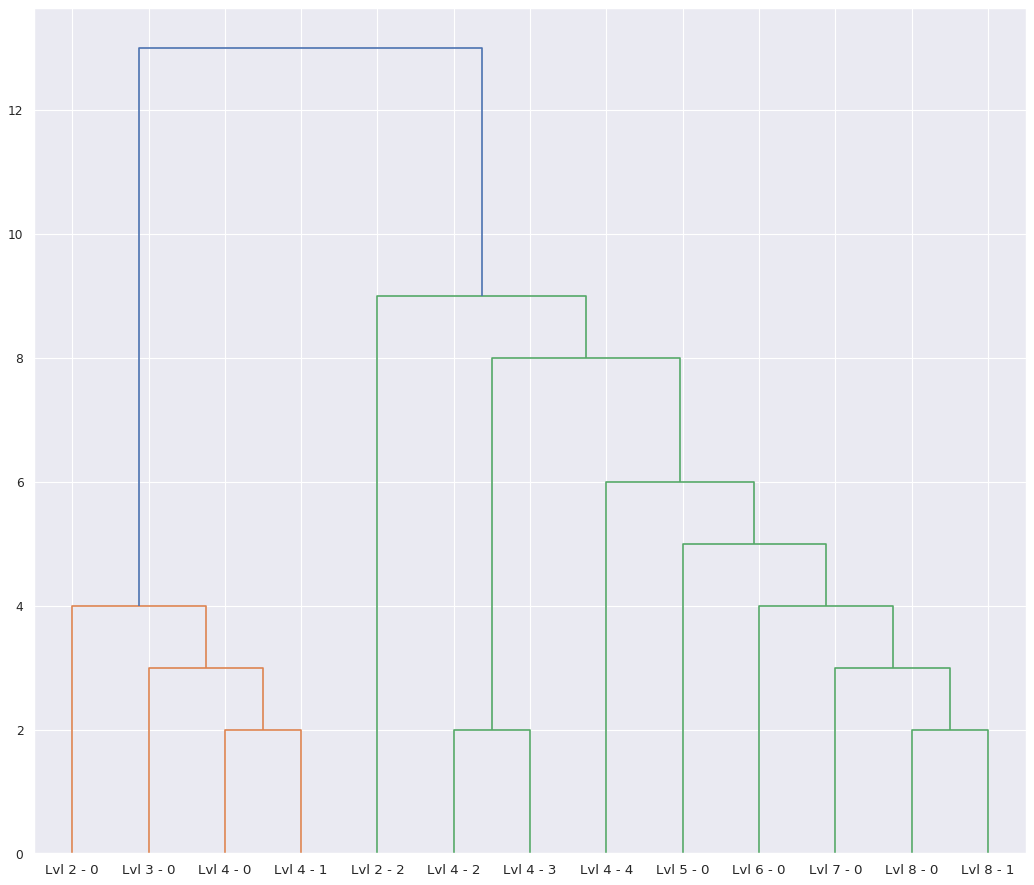

In [ ]:
# Load required modules
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(16, 14), dpi=80)

d           = TreeNode.dendrogram_dict
G           = nx.DiGraph(dict(d))
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

subtree = dict( (n, [n]) for n in leaves )

for u in inner_nodes:
    children = set()
    node_list = list(d[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += d[v]

    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix

leaves = sorted(leaves)

index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)

for i, n in enumerate(inner_nodes):
    children = d[n]
    x = children[0]

    for y in children[1:]:

        z = tuple(subtree[x] + subtree[y])
        z = tuple(sorted(z))
        i, j = index[tuple(subtree[x])], index[tuple(subtree[y])]

        Z.append([i, j, float(len(subtree[n])), len(z)]) # <-- float is required by the dendrogram function
        
        index[z] = k
        subtree[z] = list(z)
        
        x = z
        k += 1

# Visualize
dendrogram(Z, labels=leaves)

plt.show()

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(18, 16), dpi=80)

<Figure size 1440x1280 with 0 Axes>

<Figure size 1440x1280 with 0 Axes>

In [ ]:
df = pd.read_csv("Vania-Foursquare.csv")

FileNotFoundError: ignored

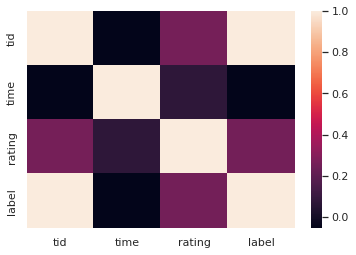

In [ ]:
# import rpy2.common as com
import seaborn as sns
%matplotlib inline


corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

# def magnify():
#     return [dict(selector="th",
#                  props=[("font-size", "7pt")]),
#             dict(selector="td",
#                  props=[('padding', "0em 0em")]),
#             dict(selector="th:hover",
#                  props=[("font-size", "12pt")]),
#             dict(selector="tr:hover td:hover",
#                  props=[('max-width', '200px'),
#                         ('font-size', '12pt')])
# ]

# corr.style.background_gradient(cmap, axis=1)\
#     .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
#     .set_caption("Hover to magify")\
#     .set_precision(2)\
#     .set_table_styles(magnify())